[![Labellerr](https://storage.googleapis.com/labellerr-cdn/%200%20Labellerr%20template/notebook.webp)](https://www.labellerr.com)

# **Perimeter Sensing Using Computer Vision**

---

[![labellerr](https://img.shields.io/badge/Labellerr-BLOG-black.svg)](https://www.labellerr.com/blog)
[![Youtube](https://img.shields.io/badge/Labellerr-YouTube-b31b1b.svg)](https://www.youtube.com/@Labellerr)
[![Github](https://img.shields.io/badge/Labellerr-GitHub-green.svg)](https://github.com/Labellerr/Hands-On-Learning-in-Computer-Vision)

This notebook implements a complete perimeter sensing system designed to monitor a specific zone within a video feed. It leverages computer vision and deep learning techniques to detect objects and identifying interactions between persons and vehicles.

## **Key Features**
*   **Interactive Region Definition**: Tools to visually draw and define a polygonal monitoring zone directly on video frames.
*   **Advanced Object Detection**: Utilizes YOLO (You Only Look Once) models to accurately detect persons and cars.
*   **Segmentation-Based Logic**: Employs YOLO segmentation masks to precisely determine physical overlap and contact between people and vehicles, offering higher accuracy than simple bounding box proximity.
*   **Real-time Monitoring & Statistics**: Displays live counts of persons within the zone and provides visual alerts and frame-by-frame statistics for contact events.

## **Workflow**
1.  **Extract Frame**: Visualize video frames to understand the scene.
2.  **Define ROI**: Use an interactive tool to draw a polygon around the area you want to monitor (e.g., a driveway or yard).
3.  **Process Video**: Run the detection pipeline which:
    *   Detects objects in every frame.
    *   Filters out objects outside your defined region.
    *   Checks for contact/overlap between detected persons and cars using segmentation masks.
    *   Annotates the video with bounding boxes, segmentation overlays, and alerts.

## 1. Import Dependencies
Import necessary libraries for image processing (OpenCV), visualization (Matplotlib), numerical operations (NumPy), and YOLO object detection models (Ultralytics).

In [13]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO

## 2. Extract Frame
Define a helper function to extract and display a specific frame from the video.

In [14]:
def extract_nth_frame(video_path, frame_number):
    """
    Extract the nth frame from a video and display it using matplotlib.
    
    Parameters:
    -----------
    video_path : str
        Path to the video file
    frame_number : int
        The frame number to extract (0-indexed)
    
    Returns:
    --------
    frame : numpy.ndarray
        The extracted frame in RGB format, or None if extraction fails
    """
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: Could not open video file {video_path}")
        return None
    
    # Get total number of frames
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Check if the requested frame number is valid
    if frame_number < 0 or frame_number >= total_frames:
        print(f"Error: Frame number {frame_number} is out of range (0-{total_frames-1})")
        cap.release()
        return None
    
    # Set the frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    
    # Read the frame
    ret, frame = cap.read()
    
    if not ret:
        print(f"Error: Could not read frame {frame_number}")
        cap.release()
        return None
    
    # Release the video capture object
    cap.release()
    
    # Convert BGR (OpenCV format) to RGB (matplotlib format)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Display the frame using matplotlib
    plt.figure(figsize=(12, 8))
    plt.imshow(frame_rgb)
    plt.title(f'Frame {frame_number}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


## 3. Video Frame by Frame Analysis
Set the path to the input video file and define a list of frame numbers that can be inspected to check different parts of the footage.

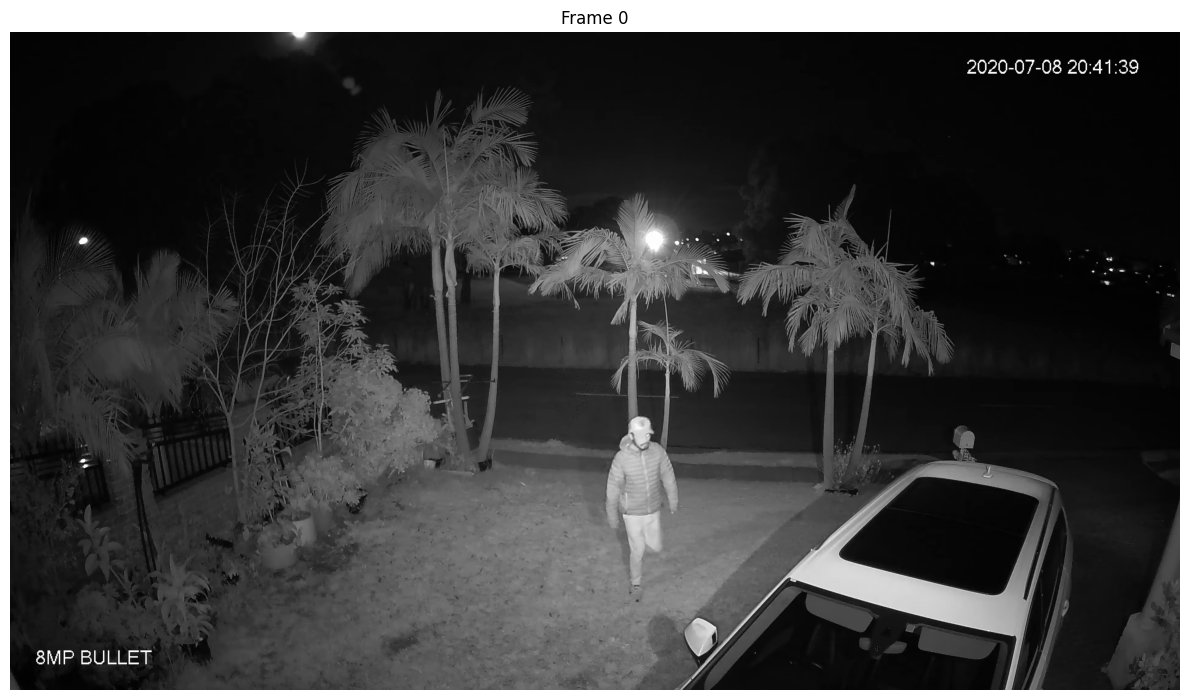

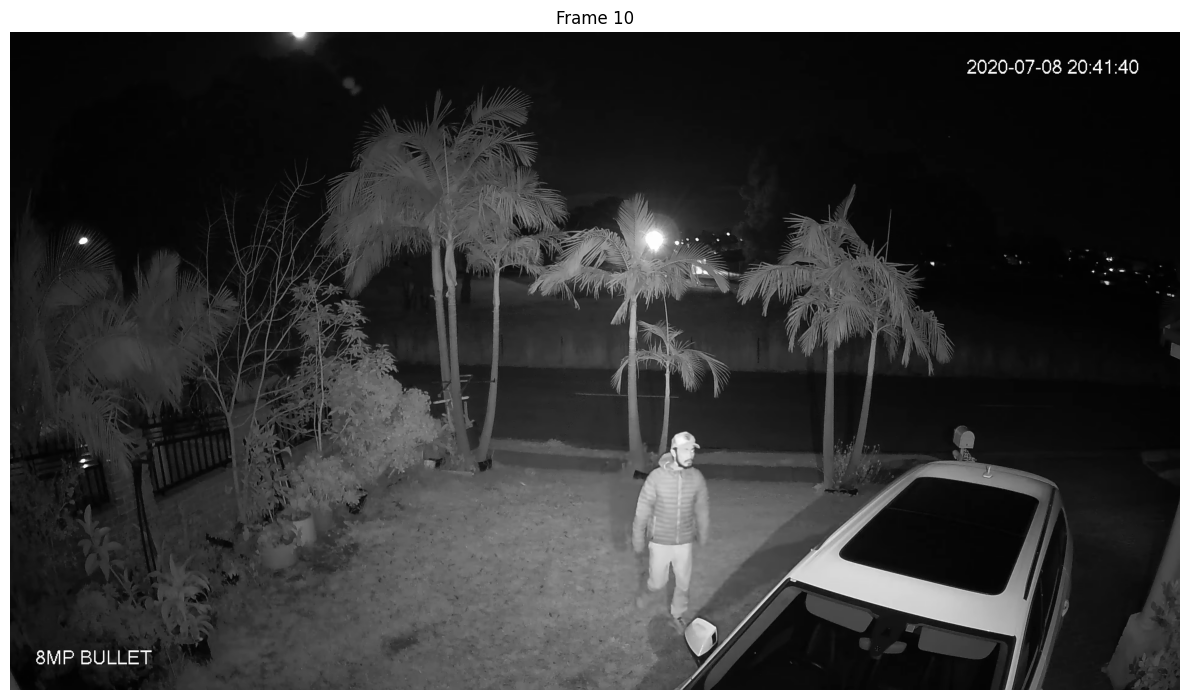

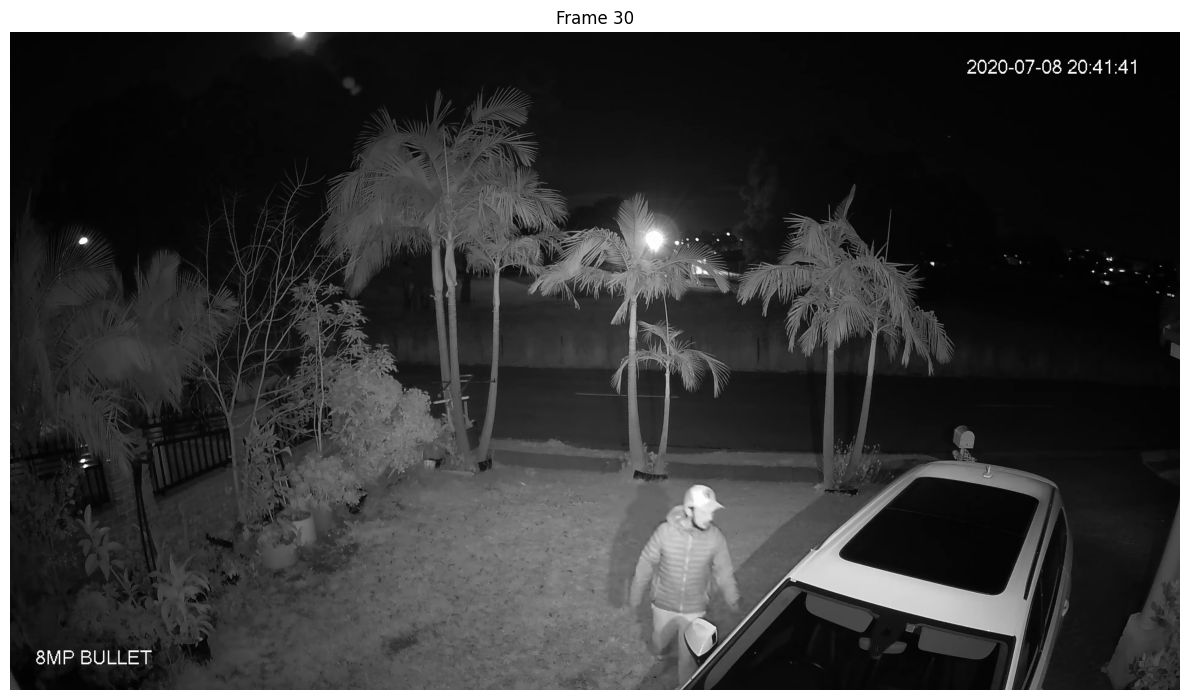

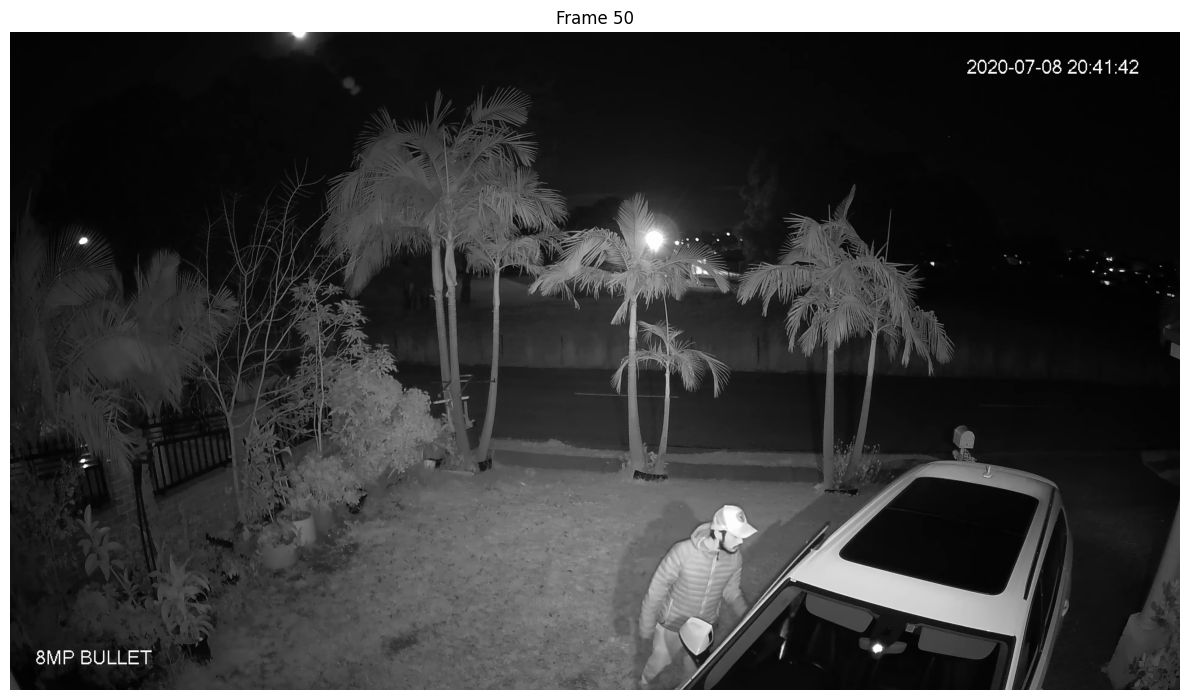

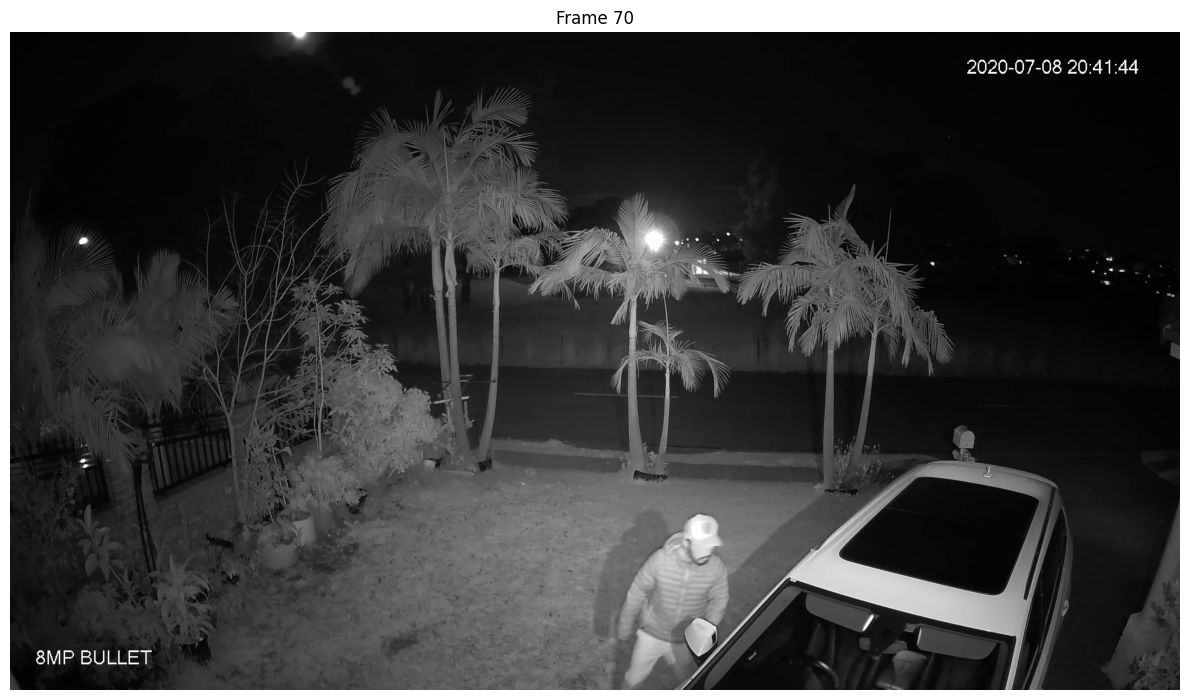

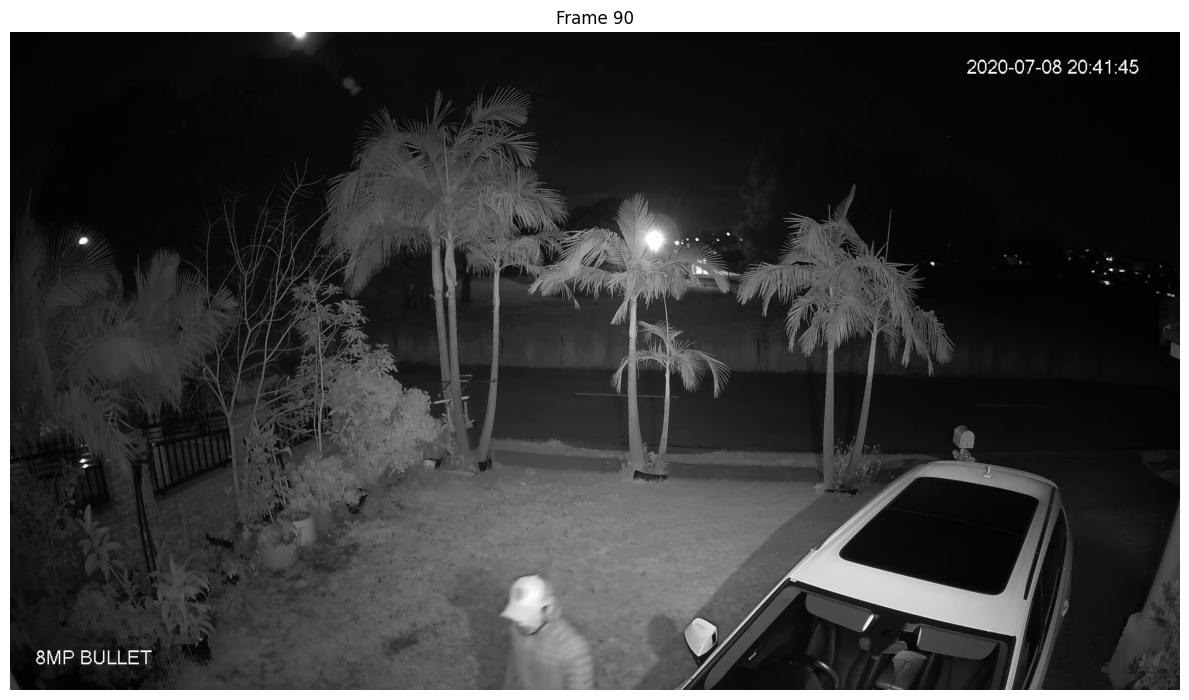

In [15]:
video_path = "video_data/cctv_1.mp4"

frame_no = [0, 10, 30, 50, 70, 90]

for frame in frame_no:
    extract_nth_frame(video_path, frame)


## 4. Setup Helper: Interactive Region Drawing
Define the `get_polygon_points` function which opens an interactive OpenCV window. This allows you to manually click points on a video frame to define your custom polygonal region of interest.

In [16]:
def get_polygon_points(video_path, frame_no=0):
    """
    Draw a polygon on a video frame using OpenCV interactive UI.
    
    Controls:
    - Left-click: Add point to polygon
    - Right-click: Finish polygon (minimum 3 points)
    - Press 'r': Reset and start over
    - Press 'c': Complete polygon (same as right-click)
    - Press 'Esc': Cancel and exit
    
    Parameters:
    -----------
    video_path : str
        Path to the video file
    frame_no : int
        Frame number to extract (default: 0)
    
    Returns:
    --------
    list : List of polygon points [(x1, y1), (x2, y2), ...]
           Returns None if drawing failed or cancelled
    
    Example:
    --------
    >>> polygon = get_polygon_points("video.mp4", frame_no=100)
    >>> print(polygon)
    [(100, 200), (300, 200), (300, 400), (100, 400)]
    """
    
    # Extract frame
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"❌ Error: Could not open video {video_path}")
        return None
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_no)
    ret, frame = cap.read()
    cap.release()
    
    if not ret:
        print(f"❌ Error: Could not read frame {frame_no}")
        return None
    
    # State variables
    points = []
    drawing_complete = False
    frame_copy = frame.copy()
    
    # Mouse callback function
    def mouse_callback(event, x, y, flags, param):
        nonlocal points, drawing_complete
        
        # Left click - add point
        if event == cv2.EVENT_LBUTTONDOWN:
            points.append((x, y))
            print(f"✓ Point {len(points)}: ({x}, {y})")
        
        # Right click - finish polygon
        elif event == cv2.EVENT_RBUTTONDOWN:
            if len(points) >= 3:
                drawing_complete = True
                print(f"✓ Polygon complete: {len(points)} points")
            else:
                print(f"⚠ Need at least 3 points (currently have {len(points)})")
    
    # Create window
    window_name = "Draw Polygon Perimeter"
    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
    cv2.setMouseCallback(window_name, mouse_callback)
    
    # Print instructions
    print("\n" + "="*70)
    print("POLYGON DRAWING - INTERACTIVE UI")
    print("="*70)
    print("  Left-click:  Add point to polygon")
    print("  Right-click: Finish polygon (minimum 3 points)")
    print("  Press 'r':   Reset and start over")
    print("  Press 'c':   Complete polygon")
    print("  Press 'Esc': Cancel and exit")
    print("="*70 + "\n")
    
    while True:
        # Create display frame
        display_frame = frame_copy.copy()
        
        # Draw all points
        for i, point in enumerate(points):
            # Draw point
            cv2.circle(display_frame, point, 6, (0, 255, 0), -1)
            cv2.circle(display_frame, point, 8, (255, 255, 255), 2)
            
            # Add point number
            cv2.putText(display_frame, str(i+1), 
                       (point[0] + 12, point[1] - 12),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            cv2.putText(display_frame, str(i+1), 
                       (point[0] + 12, point[1] - 12),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 1)
        
        # Draw lines between consecutive points
        if len(points) > 1:
            for i in range(len(points) - 1):
                cv2.line(display_frame, points[i], points[i+1], (0, 255, 0), 2)
        
        # Draw closing line and fill if polygon is complete or has 3+ points
        if len(points) >= 3:
            # Draw closing line
            cv2.line(display_frame, points[-1], points[0], (0, 255, 0), 2)
            
            # Fill polygon with semi-transparent overlay
            overlay = display_frame.copy()
            pts = np.array(points, dtype=np.int32)
            cv2.fillPoly(overlay, [pts], (0, 255, 0))
            cv2.addWeighted(overlay, 0.3, display_frame, 0.7, 0, display_frame)
        
        # Add status text at the top
        status_text = f"Points: {len(points)}"
        if drawing_complete:
            status_text = f"COMPLETE - {len(points)} points (Press any key to exit)"
            cv2.rectangle(display_frame, (5, 5), (750, 45), (0, 200, 0), -1)
        else:
            cv2.rectangle(display_frame, (5, 5), (600, 45), (0, 0, 0), -1)
        
        cv2.putText(display_frame, status_text, (15, 32),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)
        
        # Show frame
        cv2.imshow(window_name, display_frame)
        
        # Handle keyboard input
        key = cv2.waitKey(1) & 0xFF
        
        # Esc - cancel
        if key == 27:
            print("❌ Cancelled by user")
            cv2.destroyAllWindows()
            return None
        
        # 'r' - reset
        elif key == ord('r') or key == ord('R'):
            points = []
            drawing_complete = False
            print("🔄 Reset - draw a new polygon")
        
        # 'c' - complete
        elif key == ord('c') or key == ord('C'):
            if len(points) >= 3:
                drawing_complete = True
                print(f"✓ Polygon complete: {len(points)} points")
            else:
                print(f"⚠ Need at least 3 points (currently have {len(points)})")
        
        # Exit if drawing is complete
        if drawing_complete:
            cv2.waitKey(1500)  # Show final result for 1.5 seconds
            break
    
    cv2.destroyAllWindows()
    
    if len(points) < 3:
        print(f"⚠ No valid polygon drawn (need at least 3 points)")
        return None
    
    print(f"\n✅ Polygon saved with {len(points)} vertices")
    print(f"Coordinates: {points}\n")
    return points


In [17]:
perimeter_polygon = get_polygon_points(video_path, 50)


POLYGON DRAWING - INTERACTIVE UI
  Left-click:  Add point to polygon
  Right-click: Finish polygon (minimum 3 points)
  Press 'r':   Reset and start over
  Press 'c':   Complete polygon
  Press 'Esc': Cancel and exit

✓ Point 1: (2, 2150)
✓ Point 2: (1262, 1348)
✓ Point 3: (3838, 1402)
✓ Point 4: (3838, 2155)
✓ Point 5: (15, 2158)
✓ Polygon complete: 5 points

✅ Polygon saved with 5 vertices
Coordinates: [(2, 2150), (1262, 1348), (3838, 1402), (3838, 2155), (15, 2158)]



In [21]:
def annotate_frame_with_polygon(video_path, frame_number, polygon_coords):
    """
    Annotate a specific video frame with a polygon region.
    
    Parameters:
    -----------
    video_path : str
        Path to the video file.
    frame_number : int
        The frame number to extract and annotate.
    polygon_coords : list
        List of (x, y) tuples defining the polygon vertices.
        Example: [(2, 2150), (1262, 1348), (3838, 1402), (3838, 2155), (15, 2158)]
    """
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return
    # Set frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()
    
    if not ret:
        print(f"Error: Could not read frame {frame_number}")
        return
    # Create a copy for drawing
    annotated_frame = frame.copy()
    
    # Convert polygon coordinates to numpy array
    pts = np.array(polygon_coords, np.int32)
    pts = pts.reshape((-1, 1, 2))
    
    # Draw polygon: Magenta color, thickness 5
    cv2.polylines(annotated_frame, [pts], isClosed=True, color=(255, 0, 255), thickness=5)
    
    # Optional: Fill polygon with semi-transparent overlay
    overlay = annotated_frame.copy()
    cv2.fillPoly(overlay, [pts], (255, 0, 255))
    cv2.addWeighted(overlay, 0.2, annotated_frame, 0.8, 0, annotated_frame)
    # Convert to RGB for matplotlib display
    frame_rgb = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(frame_rgb)
    plt.title(f"Frame {frame_number} with ROI")
    plt.axis('off')
    plt.show()

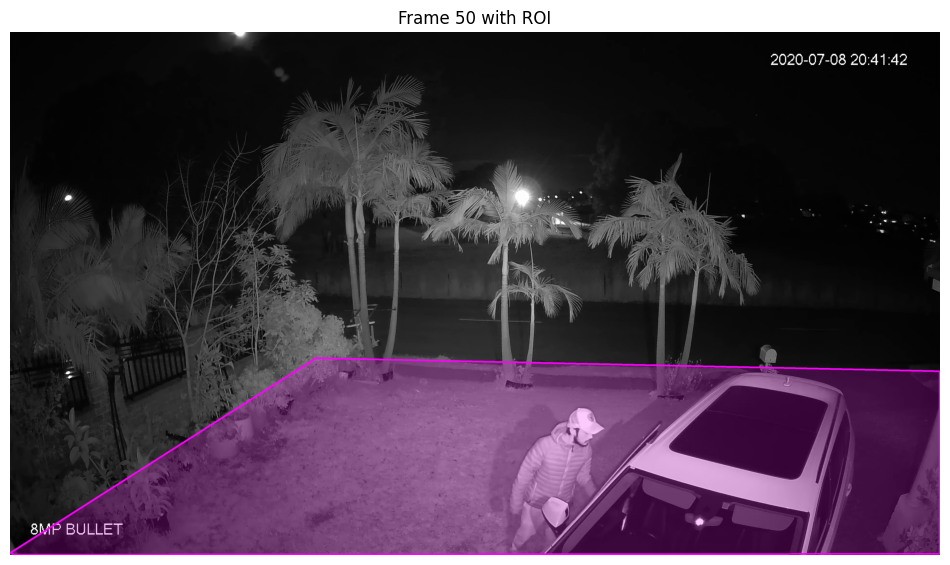

In [22]:
annotate_frame_with_polygon(video_path, 50, perimeter_polygon)

## 5. Run Perimeter Detection
Run the main `perimeter_detection` function using the defined polygon and video. This processes the video using YOLO for object detection and segmentation, checks for overlap between persons and cars within the region, and saves the annotated output with statistics.

In [19]:
def point_in_polygon(point, polygon):
    """
    Check if a point is inside a polygon using ray casting algorithm.
    
    Parameters:
    -----------
    point : tuple
        Point coordinates (x, y)
    polygon : list
        List of polygon vertices [(x1, y1), (x2, y2), ...]
    
    Returns:
    --------
    bool : True if point is inside polygon, False otherwise
    """
    x, y = point
    n = len(polygon)
    inside = False
    
    p1x, p1y = polygon[0]
    for i in range(1, n + 1):
        p2x, p2y = polygon[i % n]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or x <= xinters:
                        inside = not inside
        p1x, p1y = p2x, p2y
    
    return inside


def box_in_polygon(box, polygon):
    """
    Check if a bounding box intersects with or is inside a polygon.
    
    Parameters:
    -----------
    box : tuple
        Bounding box (x1, y1, x2, y2)
    polygon : list
        List of polygon vertices
    
    Returns:
    --------
    bool : True if box intersects polygon
    """
    x1, y1, x2, y2 = box
    
    # Check if center point is in polygon
    center_x = (x1 + x2) / 2
    center_y = (y1 + y2) / 2
    
    if point_in_polygon((center_x, center_y), polygon):
        return True
    
    # Check if any corner is in polygon
    corners = [
        (x1, y1), (x2, y1),
        (x1, y2), (x2, y2)
    ]
    
    for corner in corners:
        if point_in_polygon(corner, polygon):
            return True
    
    return False


def check_mask_overlap(person_mask, car_mask, overlap_threshold=0.05):
    """
    Check if person and car segmentation masks overlap.
    
    Parameters:
    -----------
    person_mask : numpy.ndarray
        Person segmentation mask
    car_mask : numpy.ndarray
        Car segmentation mask
    overlap_threshold : float
        Minimum overlap ratio to consider as contact (default: 0.05 = 5%)
    
    Returns:
    --------
    tuple : (is_overlap, overlap_ratio, overlap_area)
    """
    if person_mask is None or car_mask is None:
        return False, 0.0, 0
    
    # Calculate intersection
    intersection = np.logical_and(person_mask, car_mask)
    overlap_area = np.sum(intersection)
    
    # Calculate overlap ratio relative to person mask
    person_area = np.sum(person_mask)
    
    if person_area == 0:
        return False, 0.0, 0
    
    overlap_ratio = overlap_area / person_area
    
    is_overlap = overlap_ratio >= overlap_threshold
    
    return is_overlap, overlap_ratio, overlap_area


def perimeter_detection(polygon_region, video_path, 
                       detection_model_path='yolo11x.pt',
                       segmentation_model_path='yolo11x-seg.pt',
                       target_classes=['person', 'car'],
                       overlap_threshold=0.001,
                       output_path=None,
                       show_video=True):
    """
    Perform perimeter sensing with YOLO object detection and segmentation.
    
    Detects persons and cars within a polygon region, uses segmentation masks
    to check for person-car overlap/contact.
    
    Parameters:
    -----------
    polygon_region : list
        List of polygon vertices [(x1, y1), (x2, y2), ...]
    video_path : str
        Path to input video file
    detection_model_path : str
        Path to YOLO detection model (default: 'yolo11x.pt')
    segmentation_model_path : str
        Path to YOLO segmentation model (default: 'yolo11x-seg.pt')
    target_classes : list
        List of class names to detect (default: ['person', 'car'])
    overlap_threshold : float
        Minimum overlap ratio for contact detection (default: 0.05 = 5%)
    output_path : str, optional
        Path to save output video (default: None)
    show_video : bool
        Whether to display video during processing (default: True)
    
    Returns:
    --------
    dict : Statistics containing:
        - 'total_frames': Total frames processed
        - 'persons_detected': Total persons detected in region
        - 'cars_detected': Total cars detected in region
        - 'contact_events': Number of person-car contact events
        - 'frame_stats': Per-frame statistics
    
    Example:
    --------
    >>> polygon = [(2, 2145), (1325, 1380), (3828, 1485), (3832, 2153), (10, 2153)]
    >>> stats = perimeter_detection(polygon, "video.mp4")
    >>> print(f"Persons: {stats['persons_detected']}, Cars: {stats['cars_detected']}")
    """
    
    # Load models
    print("Loading YOLO models...")
    detection_model = YOLO(detection_model_path)
    segmentation_model = YOLO(segmentation_model_path)
    
    # Open video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"❌ Error: Could not open video {video_path}")
        return None
    
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Video: {width}x{height} @ {fps}fps, {total_frames} frames")
    
    # Setup output video writer if needed
    out = None
    if output_path:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    # Statistics
    stats = {
        'total_frames': 0,
        'persons_detected': 0,
        'cars_detected': 0,
        'contact_events': 0,
        'frame_stats': []
    }
    
    # Convert polygon to numpy array for drawing
    polygon_np = np.array(polygon_region, dtype=np.int32)
    
    frame_count = 0
    last_contact_frame = -100  # Track when contact was last detected
    contact_label_duration = 30  # Show label for 20 frames after contact
    
    print("\nProcessing video...")
    print("="*70)
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_count += 1
        
        # Create a copy for visualization
        display_frame = frame.copy()
        
        # Draw polygon region
        cv2.polylines(display_frame, [polygon_np], isClosed=True, 
                     color=(255, 0, 255), thickness=3)
        
        # Fill polygon with semi-transparent overlay
        overlay = display_frame.copy()
        cv2.fillPoly(overlay, [polygon_np], (255, 0, 255))
        cv2.addWeighted(overlay, 0.1, display_frame, 0.9, 0, display_frame)
        
        # Run object detection
        detection_results = detection_model(frame, verbose=False, conf=0.5)[0]
        
        # Filter detections in polygon region
        persons_in_region = []
        cars_in_region = []
        
        for box in detection_results.boxes:
            # Get box coordinates and class
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = float(box.conf[0])
            cls = int(box.cls[0])
            class_name = detection_results.names[cls]
            
            # Check if class is in target classes
            if class_name not in target_classes:
                continue
            
            # Check if box is in polygon region
            if not box_in_polygon((x1, y1, x2, y2), polygon_region):
                continue
            
            # Store detections
            if class_name == 'person':
                persons_in_region.append({
                    'box': (x1, y1, x2, y2),
                    'conf': conf
                })
            elif class_name == 'car':
                cars_in_region.append({
                    'box': (x1, y1, x2, y2),
                    'conf': conf
                })
            
            # Draw bounding box
            color = (0, 255, 0) if class_name == 'person' else (0, 0, 255)
            cv2.rectangle(display_frame, (x1, y1), (x2, y2), color, 2)
            
            # Draw label
            label = f"{class_name} {conf:.2f}"
            cv2.putText(display_frame, label, (x1, y1 - 10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        
        # Run segmentation on detected persons and cars for overlap detection
        contact_detected = False
        
        if len(persons_in_region) > 0 and len(cars_in_region) > 0:
            # Run segmentation on the frame with lower confidence threshold
            seg_results = segmentation_model(frame, verbose=False, conf=0.3)[0]
            
            # Extract masks for persons and cars in region
            if seg_results.masks is not None and len(seg_results.masks) > 0:
                masks = seg_results.masks.data.cpu().numpy()
                boxes = seg_results.boxes.xyxy.cpu().numpy()
                classes = seg_results.boxes.cls.cpu().numpy()
                
                # Create full-size masks for persons and cars
                person_masks = []
                car_masks = []
                
                for idx, (mask, box, cls) in enumerate(zip(masks, boxes, classes)):
                    class_name = seg_results.names[int(cls)]
                    
                    # Only process person and car classes
                    if class_name not in ['person', 'car']:
                        continue
                    
                    # Check if in polygon region
                    if not box_in_polygon(box, polygon_region):
                        continue
                    
                    # Resize mask to frame size
                    mask_resized = cv2.resize(mask, (width, height))
                    mask_binary = (mask_resized > 0.5).astype(np.uint8)
                    
                    if class_name == 'person':
                        person_masks.append(mask_binary)
                    elif class_name == 'car':
                        car_masks.append(mask_binary)
                
                # Debug output
                if frame_count % 30 == 0:
                    print(f"  Segmentation: {len(person_masks)} person masks, {len(car_masks)} car masks")
                
                # Check for overlaps between person and car masks
                for pidx, person_mask in enumerate(person_masks):
                    for cidx, car_mask in enumerate(car_masks):
                        is_overlap, overlap_ratio, overlap_area = check_mask_overlap(
                            person_mask, car_mask, overlap_threshold
                        )
                        
                        # Debug output for overlap
                        if frame_count % 30 == 0 and overlap_ratio > 0:
                            print(f"    Person {pidx} <-> Car {cidx}: overlap={overlap_ratio:.3f} ({overlap_area} pixels)")
                        
                        if is_overlap:
                            contact_detected = True
                            stats['contact_events'] += 1
                            last_contact_frame = frame_count  # Update last contact frame
                            
                            print(f"  🚨 CONTACT DETECTED! Frame {frame_count}, Overlap: {overlap_ratio:.1%}")
            else:
                # Debug: no masks detected
                if frame_count % 30 == 0:
                    print(f"  ⚠ No segmentation masks detected")
        
        # Show contact alert if within duration window
        if frame_count - last_contact_frame <= contact_label_duration:
            # Draw contact alert (without dark overlay)
            cv2.rectangle(display_frame, (30, 60), (850, 140), (0, 0, 255), -1)
            cv2.putText(display_frame, "WARNING: Person in Contact with Car", 
                      (50, 120),
                      cv2.FONT_HERSHEY_SIMPLEX, 2.5, (255, 255, 255), 6)
        
        # Update statistics
        stats['persons_detected'] += len(persons_in_region)
        stats['cars_detected'] += len(cars_in_region)
        stats['frame_stats'].append({
            'frame': frame_count,
            'persons': len(persons_in_region),
            'cars': len(cars_in_region),
            'contact': contact_detected
        })
        
        # Add person count display in upper right (always visible)
        # Draw background rectangle for person count
        person_count_text = f"Persons in Region: {len(persons_in_region)}"
        text_size = cv2.getTextSize(person_count_text, cv2.FONT_HERSHEY_SIMPLEX, 1.2, 3)[0]
        box_width = text_size[0] + 40
        box_x1 = width - box_width - 10
        
        cv2.rectangle(display_frame, (box_x1, 10), (width - 10, 90), (0, 150, 0), -1)
        cv2.rectangle(display_frame, (box_x1, 10), (width - 10, 90), (255, 255, 255), 3)
        
        # Draw person count
        cv2.putText(display_frame, person_count_text, (box_x1 + 20, 60),
                   cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 3)
        
        # Add frame info
        # info_text = f"Frame: {frame_count}/{total_frames} | Persons: {len(persons_in_region)} | Cars: {len(cars_in_region)}"
        # cv2.rectangle(display_frame, (10, 10), (800, 50), (0, 0, 0), -1)
        # cv2.putText(display_frame, info_text, (20, 35),
        #            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        # Write frame to output video
        if out:
            out.write(display_frame)
        
        # Display frame
        if show_video:
            cv2.imshow('Perimeter Detection', display_frame)
            
            # Press 'q' to quit, 'p' to pause
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                print("\n⚠ Stopped by user")
                break
            elif key == ord('p'):
                cv2.waitKey(0)  # Wait for any key to continue
        
        # Progress update
        # if frame_count % 30 == 0:
        #     progress = (frame_count / total_frames) * 100
        #     print(f"Progress: {progress:.1f}% | Persons: {len(persons_in_region)} | Cars: {len(cars_in_region)}")
    
    # Cleanup
    cap.release()
    if out:
        out.release()
    cv2.destroyAllWindows()
    
    stats['total_frames'] = frame_count
    
    # Print summary
    print("\n" + "="*70)
    print("PERIMETER DETECTION SUMMARY")
    print("="*70)
    print(f"Total frames processed: {stats['total_frames']}")
    print(f"Total persons detected in region: {stats['persons_detected']}")
    print(f"Total cars detected in region: {stats['cars_detected']}")
    print(f"Person-car contact events: {stats['contact_events']}")
    print("="*70 + "\n")
    
    return stats


In [20]:
stats = perimeter_detection(
                    polygon_region=perimeter_polygon,
                    video_path="video_data/cctv_1.mp4",
                    output_path="output_detection.mp4",
                    show_video=False
                    )

Loading YOLO models...
Video: 3840x2160 @ 15fps, 178 frames

Processing video...
  🚨 CONTACT DETECTED! Frame 28, Overlap: 0.1%
  🚨 CONTACT DETECTED! Frame 29, Overlap: 0.4%
  Segmentation: 1 person masks, 1 car masks
    Person 0 <-> Car 0: overlap=0.007 (874 pixels)
  🚨 CONTACT DETECTED! Frame 30, Overlap: 0.7%
  🚨 CONTACT DETECTED! Frame 31, Overlap: 0.1%
  🚨 CONTACT DETECTED! Frame 32, Overlap: 0.1%
  🚨 CONTACT DETECTED! Frame 34, Overlap: 0.1%
  🚨 CONTACT DETECTED! Frame 35, Overlap: 0.1%
  🚨 CONTACT DETECTED! Frame 38, Overlap: 0.1%
  🚨 CONTACT DETECTED! Frame 42, Overlap: 0.1%
  🚨 CONTACT DETECTED! Frame 43, Overlap: 0.1%
  🚨 CONTACT DETECTED! Frame 44, Overlap: 0.1%
  🚨 CONTACT DETECTED! Frame 45, Overlap: 0.1%
  Segmentation: 1 person masks, 1 car masks
    Person 0 <-> Car 0: overlap=0.000 (65 pixels)
  🚨 CONTACT DETECTED! Frame 62, Overlap: 0.1%
  🚨 CONTACT DETECTED! Frame 87, Overlap: 2.3%
  🚨 CONTACT DETECTED! Frame 88, Overlap: 2.8%
  🚨 CONTACT DETECTED! Frame 89, Overlap:

---

## 👨‍💻 About Labellerr's Hands-On Learning in Computer Vision

Thank you for exploring this **Labellerr Hands-On Computer Vision Cookbook**! We hope this notebook helped you learn, prototype, and accelerate your vision projects.  
Labellerr provides ready-to-run Jupyter/Colab notebooks for the latest models and real-world use cases in computer vision, AI agents, and data annotation.

---
## 🧑‍🔬 Check Our Popular Youtube Videos

Whether you're a beginner or a practitioner, our hands-on training videos are perfect for learning custom model building, computer vision techniques, and applied AI:

- [How to Fine-Tune YOLO on Custom Dataset](https://www.youtube.com/watch?v=pBLWOe01QXU)  
  Step-by-step guide to fine-tuning YOLO for real-world use—environment setup, annotation, training, validation, and inference.
- [Build a Real-Time Intrusion Detection System with YOLO](https://www.youtube.com/watch?v=kwQeokYDVcE)  
  Create an AI-powered system to detect intruders in real time using YOLO and computer vision.
- [Finding Athlete Speed Using YOLO](https://www.youtube.com/watch?v=txW0CQe_pw0)  
  Estimate real-time speed of athletes for sports analytics.
- [Object Counting Using AI](https://www.youtube.com/watch?v=smsjBBQcIUQ)  
  Learn dataset curation, annotation, and training for robust object counting AI applications.
---

## 🎦 Popular Labellerr YouTube Videos

Level up your skills and see video walkthroughs of these tools and notebooks on the  
[Labellerr YouTube Channel](https://www.youtube.com/@Labellerr/videos):

- [How I Fixed My Biggest Annotation Nightmare with Labellerr](https://www.youtube.com/watch?v=hlcFdiuz_HI) – Solving complex annotation for ML engineers.
- [Explore Your Dataset with Labellerr's AI](https://www.youtube.com/watch?v=LdbRXYWVyN0) – Auto-tagging, object counting, image descriptions, and dataset exploration.
- [Boost AI Image Annotation 10X with Labellerr's CLIP Mode](https://www.youtube.com/watch?v=pY_o4EvYMz8) – Refine annotations with precision using CLIP mode.
- [Boost Data Annotation Accuracy and Efficiency with Active Learning](https://www.youtube.com/watch?v=lAYu-ewIhTE) – Speed up your annotation workflow using Active Learning.

> 👉 **Subscribe** for Labellerr's deep learning, annotation, and AI tutorials, or watch videos directly alongside notebooks!

---

## 🤝 Stay Connected

- **Website:** [https://www.labellerr.com/](https://www.labellerr.com/)
- **Blog:** [https://www.labellerr.com/blog/](https://www.labellerr.com/blog/)
- **GitHub:** [Labellerr/Hands-On-Learning-in-Computer-Vision](https://github.com/Labellerr/Hands-On-Learning-in-Computer-Vision)
- **LinkedIn:** [Labellerr](https://in.linkedin.com/company/labellerr)
- **Twitter/X:** [@Labellerr1](https://x.com/Labellerr1)

*Happy learning and building with Labellerr!*
